In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

from src.dataframe import importDfPickle

import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

/home/eduardo/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=importDfPickle("./output/df_30mil.pkl") 

In [3]:
df.head()

,label,image,path
0,1,"[[[241, 240, 243], [241, 240, 243], [241, 240,...",images/0/10269_idx5_x1101_y901_class0.png
1,1,"[[[200, 182, 232], [210, 193, 235], [220, 211,...",images/0/9254_idx5_x1551_y1851_class0.png
2,1,"[[[206, 181, 227], [235, 230, 233], [238, 235,...",images/0/9259_idx5_x2401_y951_class0.png
3,1,"[[[226, 210, 241], [235, 232, 241], [238, 232,...",images/0/12930_idx5_x951_y1201_class0.png
4,1,"[[[242, 241, 241], [236, 236, 243], [150, 108,...",images/0/9227_idx5_x901_y1251_class0.png


In [7]:
df['label']=df['label'].replace(1,'Negativo')

In [8]:
df['label']=df['label'].replace(0,'Positivo')

In [9]:
df.loc[0,"image"].shape

(50, 50, 3)

In [10]:
df['label']=df['label'].replace('Negativo',0)

In [11]:
df['label']=df['label'].replace('Positivo',1)

In [12]:
df.head()

,label,image,path
0,0,"[[[241, 240, 243], [241, 240, 243], [241, 240,...",images/0/10269_idx5_x1101_y901_class0.png
1,0,"[[[200, 182, 232], [210, 193, 235], [220, 211,...",images/0/9254_idx5_x1551_y1851_class0.png
2,0,"[[[206, 181, 227], [235, 230, 233], [238, 235,...",images/0/9259_idx5_x2401_y951_class0.png
3,0,"[[[226, 210, 241], [235, 232, 241], [238, 232,...",images/0/12930_idx5_x951_y1201_class0.png
4,0,"[[[242, 241, 241], [236, 236, 243], [150, 108,...",images/0/9227_idx5_x901_y1251_class0.png


### Haciendo la transformada de Fourier de las imágenes

In [77]:
"""from scipy.fftpack import fft

def fftransform(array):
    '''fft to all the array images (column in this case)'''
    return np.abs(fft(array,512))
"""

In [78]:
#fftransform(resizeImages('./images/16896_idx5_x201_y1051_class1.png'))

array([[8.67060000e+04, 6.11374659e+02, 5.32811883e+02, 1.31227626e+03,
        1.43855203e+03, 7.41853586e+02, 5.86943042e+02, 1.78181712e+03,
        8.07730434e+02, 3.35865909e+02, 8.26964201e+02, 8.82614781e+02,
        7.06414212e+02, 6.03722428e+02, 2.28590045e+02, 3.30111639e+02,
        3.70419547e+02, 1.07122765e+03, 9.68515846e+02, 8.80728843e+02,
        1.53121700e+02, 3.39109563e+02, 4.13711213e+02, 6.61495407e+02,
        1.27576060e+02, 7.20546376e+02, 2.86455345e+02, 4.67944535e+02,
        4.47246431e+02, 6.33870539e+02, 3.38332646e+02, 8.89473102e+02,
        7.33058480e+02, 6.77288928e+02, 1.26892253e+02, 2.70972361e+02,
        7.28245438e+02, 7.22334993e+02, 4.54976410e+02, 6.79493997e+02,
        5.66707625e+02, 7.22312159e+02, 1.23778236e+02, 1.75907966e+02,
        3.70245774e+02, 1.98567757e+02, 3.79677085e+02, 4.59917966e+01,
        1.42978951e+02, 3.95925694e+02, 3.82451554e+02, 6.96479664e+02,
        7.12062431e+02, 2.43632102e+02, 3.24224835e+02, 5.662406

In [ ]:
#df['fft']=df['image'].apply(lambda x: fftransform(x))

In [13]:
X=np.asarray(list(df['image']))
X = X.reshape(X.shape[0], -1)
y=np.asarray(df['label'])

In [83]:
df['label'].value_counts()

0    25000
1    20000
Name: label, dtype: int64

In [14]:
X.shape

(30000, 7500)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=250)

# fit the training data to the model
clf_model=clf.fit(X_train, y_train)

In [18]:
clf_pred = clf.predict(X_test)

In [19]:
clf.predict_proba(X_test)[0:10]

array([[0.384, 0.616],
       [0.604, 0.396],
       [0.412, 0.588],
       [0.124, 0.876],
       [0.604, 0.396],
       [0.536, 0.464],
       [0.964, 0.036],
       [0.964, 0.036],
       [0.504, 0.496],
       [0.124, 0.876]])

In [20]:
y_test[0:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1])

In [21]:
clf_pred[0:10]

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1])

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score

print("Mean Absolute Error is :", mean_absolute_error(y_test, clf_pred))
print('Mean Squared Error is :', mean_squared_error(y_test, clf_pred))
print('The R2 score value is :', r2_score(y_test, clf_pred)*100)
print("Accuracy:", accuracy_score(y_test,clf_pred))

Mean Absolute Error is : 0.194
Mean Squared Error is : 0.194
The R2 score value is : 22.380129313104156
Accuracy: 0.806


In [14]:
#df_prueba = pd.DataFrame(list(zip(clf_pred , y_test)), 
              # columns =['pred', 'lo que es']) 

In [24]:
import numpy as np
scores = pd.DataFrame({
    "predicted":clf_pred,
    "gt":y_test
})
scores["diff"] = np.abs(scores["predicted"]-scores["gt"])
#scores["diff"].sum()/ len(y_test)

,gt,predicted,proba Beningno,proba Maligno
0,0,1,0.384,0.616
1,1,0,0.604,0.396
2,1,1,0.412,0.588
3,1,1,0.124,0.876
4,0,0,0.604,0.396


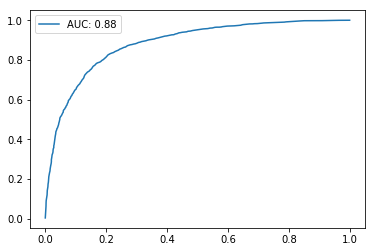

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_score = clf.predict_proba(X_test)

#print(y_score)
roc = roc_curve(y_test, y_score[:,1])
display(pd.DataFrame({
    "gt":y_test,
    "predicted":clf_pred,
    "proba Maligno":y_score[:,1],
    "proba Beningno":y_score[:,0]
}).head())

plt.plot(roc[0],roc[1])
plt.legend(["AUC: {}".format(round(roc_auc_score(y_test, y_score[:,1]),2))])


In [27]:
pd.crosstab(y_test, clf_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,2481,567
1,597,2355


In [32]:
import pickle
def saveTrainedModel(model,modelname):
    filename = './output/models/{}.sav'.format(modelname)
    pickle.dump(model, open(filename, 'wb')) 

In [33]:
modelname='rfc_model'
saveTrainedModel(clf_model,modelname)

### Predicción con nuevas imágenes

In [36]:
import cv2
def resizeImages(img_path,size=(50,50)):
    "resize all images to 50x50"
    image = cv2.imread(img_path)
    resized = cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)
    img=np.array([resized.flatten()])
    #print('resized image')
    return img

In [37]:
def predictNewImage(path):
    im = resizeImages(path)
    pred_nueva=clf.predict(im)
    print(pred_nueva)
    if pred_nueva == 0:
        print('Tumor benigno')
    else:
        print('Tumor maligno')
    return pred_nueva

In [38]:
import re 

for file in glob.glob('./images/*.png'):
    print(file, predictNewImage(file))


[1]
Tumor maligno
./images/16166_idx5_x901_y1001_class1.png [1]
[1]
Tumor maligno
./images/16166_idx5_x901_y1051_class1.png [1]
[0]
Tumor benigno
./images/16166_idx5_x301_y901_class0.png [0]
[1]
Tumor maligno
./images/16166_idx5_x901_y901_class1.png [1]
[0]
Tumor benigno
./images/16166_idx5_x201_y1251_class0.png [0]
[0]
Tumor benigno
./images/16166_idx5_x201_y851_class0.png [0]
[0]
Tumor benigno
./images/16166_idx5_x151_y1101_class0.png [0]
[1]
Tumor maligno
./images/16166_idx5_x901_y951_class1.png [1]


### Otros modelos

In [182]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [175]:
df2=importDfPickle("./output/breast_cancer_2000m.pkl") 

In [176]:
X_grad=np.asarray(list(df['image']))
X_grad = X_grad.reshape(X_grad.shape[0], -1)
y_grad=np.asarray(df['label'])

In [177]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_grad, y_grad, test_size=0.2, random_state=42)

In [183]:
gb_clf = KNeighborsClassifier()
gb_clf.fit(X_train2, y_train2)

MemoryError: Unable to allocate array with shape (36000, 7500) and data type float64

In [ ]:
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

### Chequear si las imágenes están en el dataset

In [ ]:
x='images/0/15840_idx5_x151_y551_class0.png'

In [167]:
c='images/1/14304_idx5_x1601_y401_class1.png'

In [169]:
if c in df['path']:
    print('imagen en dataset')

In [ ]:
./images/12867_idx5_x1851_y1351_class1.png

In [166]:
df.path

0        images/1/12867_idx5_x1851_y1351_class1.png
1        images/1/16167_idx5_x2201_y1701_class1.png
2        images/1/12821_idx5_x1651_y1551_class1.png
3        images/1/13691_idx5_x3651_y1901_class1.png
4        images/1/14154_idx5_x1801_y1501_class1.png
5         images/1/14304_idx5_x1601_y401_class1.png
6         images/1/9022_idx5_x2151_y1051_class1.png
7        images/1/10273_idx5_x1101_y1351_class1.png
8         images/1/8975_idx5_x2351_y1251_class1.png
9         images/1/15473_idx5_x2101_y901_class1.png
10       images/1/10273_idx5_x1501_y1051_class1.png
11       images/1/10299_idx5_x2301_y1751_class1.png
12       images/1/12819_idx5_x1451_y2451_class1.png
13        images/1/10302_idx5_x1801_y351_class1.png
14       images/1/12930_idx5_x2251_y1701_class1.png
15       images/1/10273_idx5_x1351_y1501_class1.png
16         images/1/8917_idx5_x1051_y651_class1.png
17       images/1/13019_idx5_x1851_y1351_class1.png
18       images/1/12935_idx5_x2051_y1651_class1.png
19        im